# Requirements

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
import evaluate
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of Spotify user reviews. The dataset contains two attributes:

+ **review** - A text column containing user feedback, opinions, and experiences with the Spotify application.
+ **sentiment** - A categorical column indicating whether the review has a positive or negative sentiment.

Your task involves training a model to predict the **sentiment** (either "positive" or "negative") based on the content of the **review**.

## The Spotify User Reviews Dataset

Load the dataset using the `datasets` library.

In [12]:
dataset = load_dataset("csv", data_files="spotify-user-reviews.csv")
dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 10000
    })
})

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [13]:
df = dataset["train"].to_pandas()
df

,review,label
0,A huge collection of music,positive
1,Downloaded music still can't be played offline...,negative
2,This app is the best music app I have ever see...,positive
3,"Works great just with the car's Bluetooth, but...",negative
4,Best music app so far,positive
...,...,...
9995,All of a sudden the app will not work on my S22+,negative
9996,THE BEST MUSIC APP EVER! I WOULD GIVE IT INFIN...,positive
9997,I used to love this app..even though it had so...,negative
9998,Great app. Wish I could add multiple tracks fr...,negative


In [15]:
encoder = LabelEncoder()

labels = encoder.fit_transform(dataset["train"]["label"])

In [17]:
dataset["train"] = dataset["train"].remove_columns("label")
dataset["train"] = dataset["train"].add_column("label", labels)
dataset = dataset.rename_column("review", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
})

In [18]:
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [20]:
checkpoint = "google-bert/bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [21]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [22]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define the traning parameters using the `TrainingArguments` class.

In [27]:
training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    metric_for_best_model="f1",
    num_train_epochs=3,
    report_to="none",
)

Define the training using the `Trainer` class.

In [31]:
metric = evaluate.load("f1")

In [32]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [37]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [38]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Fine-tune (train) the pre-trained lanugage model.

In [39]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.386400,0.340974,0.878327
2,0.293300,0.289986,0.909970
3,0.185000,0.341815,0.918497


TrainOutput(global_step=3000, training_loss=0.2951005452473958, metrics={'train_runtime': 690.8547, 'train_samples_per_second': 34.74, 'train_steps_per_second': 4.342, 'total_flos': 1138839203133600.0, 'train_loss': 0.2951005452473958, 'epoch': 3.0})

Use the trained model to make predictions for the test set.

In [40]:
predictions = trainer.predict(tokenized_dataset["test"])

In [41]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [43]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       993
           1       0.93      0.91      0.92      1007

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



Text(0.5, 1.0, 'Confusion Matrix')

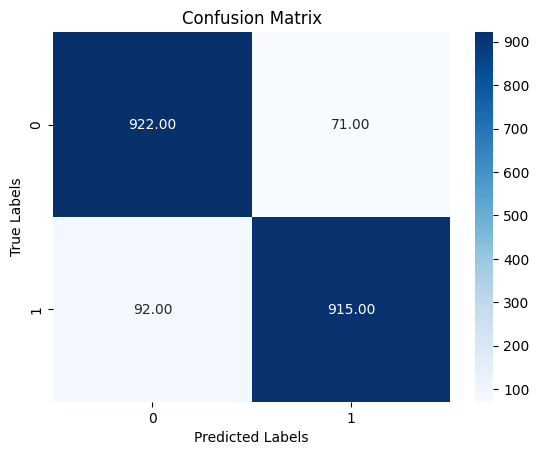

In [44]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a machine learning pipeline to classify Spotify user reviews as positive or negative. Use TF-IDF vectorization to transform the review text into numerical features, and train a logistic regression model on the transformed data. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. To gain insights into the most influential words or phrases associated with positive and negative reviews, analyze the coefficients from the logistic regression model trained on the TF-IDF features. Present the top keywords for each sentiment in a table or a bar chart to provide a clear understanding of the terms driving user feedback.

In [47]:
tv = TfidfVectorizer(binary=False, norm='l2', use_idf=False, smooth_idf=False, lowercase=True, stop_words='english', token_pattern=r'(?u)\b[A-Za-z]+\b', min_df=1, max_df=1.0, max_features=None, ngram_range=(1, 1))


In [48]:
data = pd.read_csv('spotify-user-reviews.csv')
data.columns

Index(['review', 'label'], dtype='object')

In [49]:
X = data['review']
y = data['label']

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [51]:
model_reg = LogisticRegression()

In [52]:
model = make_pipeline(tv, model_reg)

In [53]:
model.fit(X_train, Y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(smooth_idf=False, stop_words='english',
                                 token_pattern='(?u)\\b[A-Za-z]+\\b',
                                 use_idf=False)),
                ('logisticregression', LogisticRegression())])

In [54]:
y_pred = model.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.85      0.87      0.86       990
    positive       0.87      0.85      0.86      1010

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



In [55]:
terms = tv.get_feature_names_out()
terms

array(['aa', 'aaaa', 'aaaaasssseeeeee', ..., 'zindagi', 'zone', 'zoomed'],
      dtype=object)

In [56]:
coef = model_reg.coef_[0]
pos = np.argsort(coef)[-10:]
neg = np.argsort(coef)[:10]

In [57]:
top_positive_terms = [(terms[i], coef[i]) for i in pos]
top_negative_terms = [(terms[i], coef[i]) for i in neg]

In [58]:
keywords_df = pd.DataFrame({
    'Positive Terms': [t[0] for t in top_positive_terms],
    'Positive Coefficients': [t[1] for t in top_positive_terms],
    'Negative Terms': [t[0] for t in top_negative_terms],
    'Negative Coefficients': [t[1] for t in top_negative_terms]
})

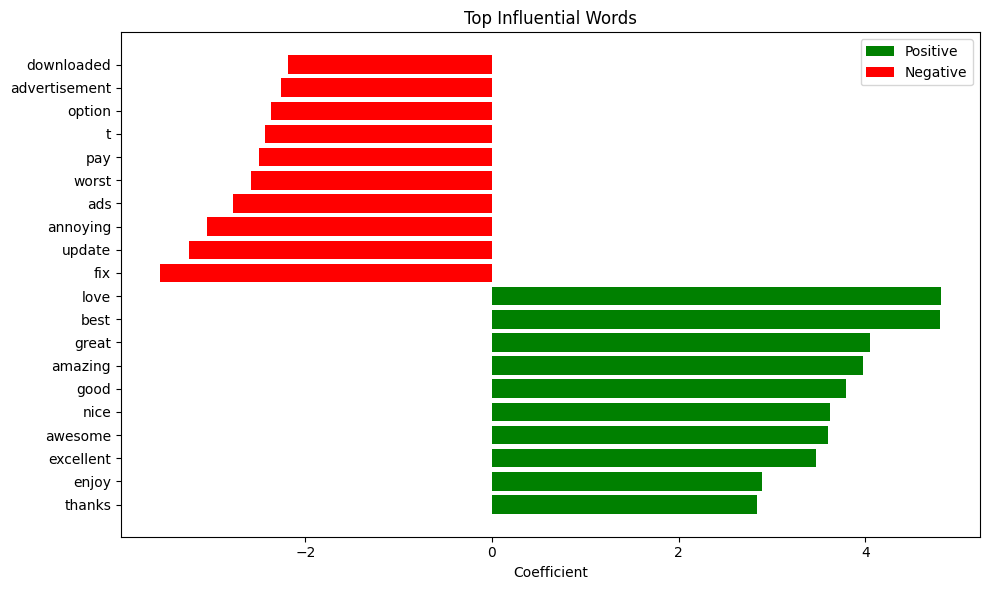

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(
    [t[0] for t in top_positive_terms],
    [t[1] for t in top_positive_terms],
    color='green',
    label='Positive'
)
plt.barh(
    [t[0] for t in top_negative_terms],
    [t[1] for t in top_negative_terms],
    color='red',
    label='Negative'
)
plt.xlabel('Coefficient')
plt.title('Top Influential Words')
plt.legend()
plt.tight_layout()
plt.show()